In [1]:
# simulate parameterized multichannel non-causal Wiener filter (PMWF), suppose that the noise
# samples are known for any processed data frame

The RT60 is 82 ms
(6, 201674)
(257, 794, 6)
(257, 787, 6)


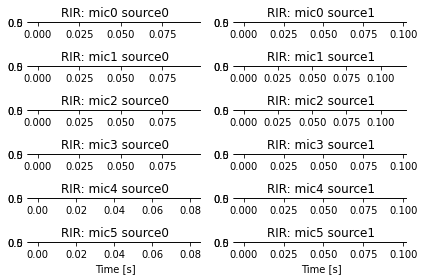

In [2]:
import numpy as np
import librosa
from scipy.fftpack import fft
import matplotlib.pyplot as plt
from DistantSpeech.transform.transform import Transform
from DistantSpeech.beamformer.utils import pmesh, mesh, load_wav, save_audio, load_pcm
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.beamformer.MicArray import MicArray, ArraySim
from DistantSpeech.beamformer.beamformer import beamformer
from DistantSpeech.beamformer.MicArray import MicArray, compute_tau
from DistantSpeech.noise_estimation.mcra import NoiseEstimationMCRA
from DistantSpeech.noise_estimation.mcra2 import MCRA2

sampling_frequency = 16000
fft_length = 512
fft_shift = 256
mic_diameter = 0.1
sound_speed = 343
look_direction = 30

signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3_2.wav")
noise = audioread("/home/wangwei/work/DistantSpeech/samples/noise/office1.wav")
fs = 16000
M = 6
mic_array = MicArray(arrayType="circular", r=mic_diameter/2, M=M)
mic_array_sim = mic_array.array_sim
# print(mic_array_sim.R)
array_data, premix = mic_array_sim.generate_audio(signal, interference=noise, source_angle=look_direction, interf_angle=270, sir=10, snr=30)
# audiowrite('mix.wav', np.transpose(array_data))
# audiowrite('signal.wav', np.transpose(premix[0, :, :]))
# audiowrite('interf.wav', np.transpose(premix[1, :, :]))

print(array_data.shape)
M = array_data.shape[0]
transform = Transform(n_fft=512, hop_length=256, channel=M)
D = transform.stft(np.transpose(array_data))
Noise = transform.stft(np.transpose(premix[1, :M, :]))
print(Noise.shape)
half_bin = D.shape[0]
frame_num = D.shape[1]
print(D.shape)

In [4]:
Rvv = np.zeros((M,M, half_bin), dtype=complex)
Ryy = np.zeros((M,M, half_bin), dtype=complex)
Rxx = np.zeros((M,M, half_bin), dtype=complex)
xi = np.zeros((frame_num, half_bin))
Rvv1 = np.zeros((frame_num, half_bin))
Rvv_inv = np.zeros((M, M, half_bin),dtype=complex)
w_mvdr = np.zeros((M,half_bin),dtype=complex)
w = np.zeros((M,half_bin),dtype=complex)
Yout_mvdr = np.zeros((half_bin, frame_num), dtype=complex)
Yout = np.zeros((half_bin, frame_num), dtype=complex)
p = np.zeros((half_bin, frame_num, ))


def normalize(steering_vector):
    for ii in range(0, fft_length):            
        weight = np.matmul(np.conjugate(steering_vector[:, ii]).T, steering_vector[:, ii])
        steering_vector[:, ii] = (steering_vector[:, ii] / weight) 
    return steering_vector   

def get_sterring_vector_mic(look_direction=0):
    freq_bin = np.linspace(0, half_bin - 1, half_bin)
    omega = 2 * np.pi * freq_bin * sampling_frequency / fft_length
    a = np.zeros((M, half_bin), dtype=complex)
    for k in range(half_bin):
        tau = compute_tau(mic_array=mic_array, incident_angle=np.array([look_direction, 0]) * np.pi / 180)
        a[:, k:k+1] = np.exp(-1j * omega[k] * tau)

    return a # [M, half_bin]

steer_vector = get_sterring_vector_mic(look_direction=look_direction)  # [M, freq]
print(steer_vector[:,0])

noise_estimator = NoiseEstimationMCRA(nfft=fft_length)
# noise_estimator = MCRA2(nfft=fft_length)
noise_estimator.L = 15
u = np.zeros((M,1))
u[0,0] = 1
alpha_yy = 0.85
alpha_vv = 0.92
for n in range(frame_num):
    y = D[:, n, :] # [F,M]
    noise = Noise[:, n, :] # [F,M]
    psd_yy = np.einsum('ij,il->ijl', y, y.conj())
    psd_vv = np.einsum('ij,il->ijl', noise, noise.conj())
    Ryy = alpha_yy * Ryy + (1 - alpha_yy) * (np.transpose(psd_yy, (1, 2, 0)))
    # Rvv = alpha_vv * Rvv + (1 - alpha_vv) * (np.transpose(psd_vv, (1, 2, 0)))
    noise_estimator.estimation(np.abs(y[:, 0])**2)
    p[:, n] = noise_estimator.p
    for k in range(half_bin):
        alpha_tilde = alpha_vv + (0.98 - alpha_vv) * noise_estimator.p[k]
        alpha_tilde = alpha_vv

        Rvv[:, :, k] = alpha_tilde * Rvv[:, :, k] + (1-alpha_tilde) * (np.transpose(psd_vv, (1, 2, 0)))[:, :, k]
        diag_value = 1e-6
        Rvv_inv[:, :, k] = np.linalg.inv(Rvv[:, :, k] + np.eye(M) * diag_value)
        Rxx[:, :, k] = Ryy[:, :, k] - Rvv[:, :, k]
        xi[n, k] = np.real(np.trace(Rvv_inv[:, :, k] @ Ryy[:, :, k])) - M
        Rvv_inv_k = Rvv_inv[:, :, k]
        if xi[n, k] < 0:
            Rvv_inv_k = np.linalg.inv(Ryy[:, :, k] + np.eye(M) * 1e-1)
            xi[n, k] = np.real(np.trace(Rvv_inv_k @ Ryy[:, :, k])) - M
            
        w[:, k:k+1] = (Rvv_inv_k @ Ryy[:, :, k] - np.eye(M))@u/(xi[n, k])
        w_mvdr[:, k:k+1] = Rvv_inv[:, :, k] @ steer_vector[:, k:k+1]/(steer_vector[:, k:k+1].conj().T@Rvv_inv[:, :, k]@steer_vector[:, k:k+1])

        Yout[k, n] = w[:, k:k+1].conj().T@y[k, :].T
        Yout_mvdr[k, n] = w_mvdr[:, k:k+1].conj().T@y[k, :].T

pmesh(librosa.power_to_db(np.abs(D[:, :, 0])))
pmesh(librosa.power_to_db(np.abs(Yout)))
pmesh(librosa.power_to_db(np.abs(Yout_mvdr)))
yout = transform.istft(Yout)
# audiowrite('audio.wav', yout)

[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
